In [1]:
 #%matplotlib inline
import numpy as np
import pickle
import os
#from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [3]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

In [31]:
# encoder/decoder network size
batch_size=50
original_dim=6170 # number of locations
intermediate_dim=600
latent_dim=200
nb_epochs=200 
epsilon_std=1.0

In [41]:
6170/50 

123.4

In [32]:
# encoder network
x=Input(batch_shape=(batch_size,original_dim)) 
h=Dense(intermediate_dim, activation='relu')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

In [33]:
# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [34]:
# decoder network
h_decoder=Dense(intermediate_dim, activation='relu')
x_bar=Dense(original_dim,activation='softmax') 
h_decoded = h_decoder(z) 
x_decoded = x_bar(h_decoded)

In [35]:
# build and compile model
vae = Model(x, x_decoded)

def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss= -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss + reconst_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [36]:
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (50, 6170)           0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (50, 600)            3702600     input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (50, 200)            120200      dense_11[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (50, 200)            120200      dense_11[0][0]                   
____________________________________________________________________________________________

In [37]:
x_train = pickle.load( open( os.path.join("..","..","data","train_data.file"), "rb" ) )
print("number of training users: ", x_train.shape[0])

x_val = pickle.load( open(os.path.join("..","..","data","val_data.file"), "rb" ) )
x_val = x_val.todense() 
print("number of validation users: ", x_val.shape)

number of training users:  50870
number of validation users:  (10000, 6170)


In [38]:
def nn_batch_generator(x, y, batch_size, steps_per_epoch):
    number_of_batches = steps_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].todense() # returns a matrix
        y_batch = y[index_batch,:].todense()
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0

In [45]:
weightsPath = os.path.join("..","tmp","weights_yn.hdf5")
# if not os.path.exists(weightsPath):
#     os.makedirs(weightsPath)

checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

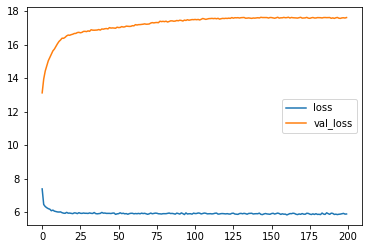

In [47]:
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 122), 
                  samples_per_epoch=122, nb_epoch=nb_epochs, 
                  validation_data=(x_val, x_val), 
                  callbacks=[checkpointer, reduce_lr, plot_losses])

# 전체학습 시키기

In [29]:
x_train = pickle.load( open( os.path.join("..","..","data","all_data2.file"), "rb" ) )
print("number of training users: ", x_train.shape[0])

x_val = pickle.load( open(os.path.join("..","..","data","val_data2.file"), "rb" ) )
x_val = x_val.todense() 

number of training users:  6170


In [71]:
# encoder/decoder network size
batch_size=1000
original_dim=70870 # number of users
intermediate_dim=600
latent_dim=2000
nb_epochs=200 
epsilon_std=1.0

In [72]:
# encoder network
x=Input(batch_shape=(batch_size,original_dim)) 
h=Dense(intermediate_dim, activation='relu')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# decoder network
h_decoder=Dense(intermediate_dim, activation='relu')
x_bar=Dense(original_dim,activation='softmax') 
h_decoded = h_decoder(z) 
x_decoded = x_bar(h_decoded)

In [73]:
# build and compile model
vae = Model(x, x_decoded)

def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss= -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss + reconst_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [74]:
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (1000, 70870)        0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (1000, 600)          42522600    input_4[0][0]                    
__________________________________________________________________________________________________
dense_15 (Dense)                (1000, 2000)         1202000     dense_14[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (1000, 2000)         1202000     dense_14[0][0]                   
____________________________________________________________________________________________

In [75]:
# weightsPath = os.path.join("..","tmp","weights_all_yn.hdf5")
# checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [76]:
def nn_batch_generator(x, y, batch_size, steps_per_epoch):
    number_of_batches = steps_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].todense() # returns a matrix
        y_batch = y[index_batch,:].todense()
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0

In [82]:
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 70), 
                  samples_per_epoch=70, nb_epoch=nb_epochs, 
                  validation_data=(x_val, x_val))
#, 
 #                 callbacks=[checkpointer, reduce_lr, plot_losses])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=(matrix([[..., steps_per_epoch=70, epochs=200)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/200


KeyboardInterrupt: 

# vector 뽑기

In [4]:
%matplotlib inline 
import numpy as np 
import pickle 
import os 
import math 
from keras.layers import Input, Dense, Lambda 
from keras.models import Model, load_model 
from keras import objectives 
from keras import backend as K 
from sklearn.cluster import KMeans 
#from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt 
from bhtsne import tsne 

In [5]:
# encoder/decoder network size
batch_size=100
original_dim=70870 # number of users
intermediate_dim=600
latent_dim=200
nb_epochs=200 
epsilon_std=1.0

In [6]:
# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='tanh')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

def sampling(args):
    _mean,_log_var=args
    # does this mean we are modelling this is as a gaussian and not multinomial?
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# decoder network
h_decoder=Dense(intermediate_dim, activation='tanh')
x_bar=Dense(original_dim,activation='softmax')
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

In [27]:
vae = Model(x, x_decoded)
weightsPath = os.path.join("..","tmp","weights_all_yn.hdf5")
vae.load_weights(weightsPath) 

ValueError: Shapes (70870, 600) and (6170, 600) are incompatible

In [8]:
x_all_matrix = pickle.load(open(os.path.join("..","..","data","all_data2.file"), "rb" ))
x_all_matrix = x_all_matrix.todense()  # 1s and 0s per user
x_all = np.squeeze(np.asarray(x_all_matrix)) 

In [9]:
encoder = Model(x, z_mean) 
x_all_encoded = encoder.predict(x_all, batch_size=batch_size) 
print(x_all_encoded.shape)

(6170, 200)


In [19]:
x_all_encoded

array([[-0.00559809,  0.02461329,  0.0181872 , ..., -0.02407795,
         0.00658787,  0.00743612],
       [ 0.08543789, -0.12494101,  0.00378912, ..., -0.02279352,
         0.06115444,  0.06329228],
       [ 0.05105601, -0.00458951,  0.05931875, ..., -0.10566042,
        -0.12155318,  0.05215371],
       ...,
       [-0.00544716,  0.00459696, -0.00648626, ..., -0.00836409,
        -0.00121843,  0.00634888],
       [ 0.00036472,  0.00585111,  0.00563995, ..., -0.01262585,
         0.00479929, -0.00152971],
       [ 0.00036472,  0.00585111,  0.00563995, ..., -0.01262585,
         0.00479929, -0.00152971]], dtype=float32)

In [23]:
new_df = pd.read_csv(os.path.join("..","..","data","TA_User_Reviws_Korea_all_v2_new_df.csv"))
new_df = new_df.drop(['location_name'], axis=1)
unique_location_ids = new_df.locationId.unique()
unique_location_ids

array([  299152,   299154,   299502, ..., 20494843, 20860800, 20903295])

In [43]:
def location_latent(encoded, unique_location_ids):
    encoded_location_df = pd.DataFrame(encoded)
    print(encoded_location_df.shape)

    encoded_location_df['location_ids'] = unique_location_ids
    encoded_location_df = encoded_location_df.set_index('location_ids')
    return encoded_location_df

In [57]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, item_id, top):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
        
    new_vec = vec.copy()
    sim = []
    for i in range(len(vec)):
        if i != item_id:
            sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))
    new_vec['sim'] = sim
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    top_n = new_vec.head(top)['location_ids'].tolist()
    if item_id in top_n:
        top_n.remove(item_id)
    return top_n

In [59]:
def sim_item(vec, df, item_id, top):
    item_name = pickle.load(open(os.path.join("..","..","data",'item_name.pickle'),"rb"))
    
    top_id = cosim_id(vec, item_id, top)
    df = df.loc[df['locationId'].isin(top_id)]
    top_id = df.loc[df['placeType']!= 'ACCOMMODATION'].drop_duplicates(['locationId'], keep='last')
    top_id = top_id.sort_values('average_rating', ascending=False)
    top_id = top_id['locationId'].unique().tolist()
    print('input location:', item_name[item_id])
    for i in top_id:
        print(item_name[i]) 

In [47]:
vec = location_latent(x_all_encoded, unique_location_ids)
print(vec.shape)

(6170, 200)
(6170, 200)


In [60]:
sim_item(vec, new_df, 299533, 10)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in float_scalars
  


input location: {'location.name': 'ibis styles Ambassador Seoul Gangnam'}
{'location.name': 'Hoya Sushi Tuna Speciality'}


In [61]:
sim_item(vec, new_df, 19735623, 10)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in float_scalars
  


input location: {'location.name': 'Toyoko Inn Seoul Yeongdeungpo'}
{'location.name': 'Cheongdam Ros'}
{'location.name': 'Bass'}
{'location.name': 'Seogyo Garden'}
{'location.name': 'Samcheongdong Bingbing Bing'}


# 시각화

In [10]:
from sklearn.cluster import KMeans 
#from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt 
from bhtsne import tsne 

In [17]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(x_all_encoded)
x_all_cluster_labels = kmeans.labels_

In [14]:
x_all_2_embedded = tsne(x_all_encoded.astype('float64'))
print(x_all_2_embedded.shape)

(6170, 2)


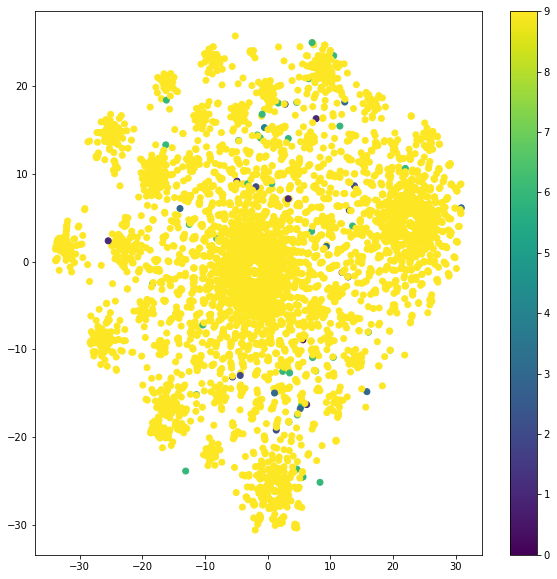

In [18]:
plt.figure(figsize=(10, 10))
plt.scatter(x_all_2_embedded[:, 0], x_all_2_embedded[:, 1], c=x_all_cluster_labels)
plt.colorbar()
plt.show()